In [1]:
"""
!pip install pandas
!pip install keras
!pip install h5py
!pip install pillow
!pip install scikit-learn
!pip install matplotlib
!pip install requests

!mkdir test_imgs train_imgs val_imgs
"""

'\n!pip install pandas\n!pip install keras\n!pip install h5py\n!pip install pillow\n!pip install scikit-learn\n!pip install matplotlib\n!pip install requests\n\n!mkdir test_imgs train_imgs val_imgs\n'

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import sys
from capsulenet import CapsNet, margin_loss

/home/alliedtoasters/miniconda3/envs/dev1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def parse_labels(lbls):
    """takes a string and returns list of numeric labels"""
    result = lbls[2:][:-2]
    result = result.split("', '")
    return result

#!unzip train_imgs.csv.zip
df = pd.read_csv('train_imgs.csv').copy()
df.index = df.img_id.astype(int)

def update_progress(progress):
    """Displays or updates a console progress bar
    Accepts a float between 0 and 1. Any int will be converted to a float.
    A value under 0 represents a 'halt'.
    A value at 1 or bigger represents 100%
    """
    barLength = 25 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rProgress: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), round(progress*100, 2), status)
    sys.stdout.write(text)
    sys.stdout.flush()

def features_to_sparse(df, filename='sparse_features.npz'):
    """Converts labels to sparse matrix. Tries loading
    file; if fails, does all the work and saves it (takes a bit.)
    """
    try:
        result = load_npz(filename)
        return result
    except:
        print('file not found. Creating...')
    total_rows = len(df)
    row = []
    col = []
    data = []
    for idx in df.index:
        progress = idx/total_rows
        update_progress(progress)
        df_row = df.loc[idx]
        labels = parse_labels(df_row.lbls)
        for lbl in labels:
            row.append(idx-1)
            col.append(int(lbl)-1)
            data.append(1)
            
    row, col, data = np.array(row), np.array(col), np.array(data)
    result = csr_matrix((data, (row, col)), shape=(max(row)+1, max(col)+1))
    save_npz(filename, result)
    return result

mat = features_to_sparse(df)

In [4]:
totals = mat.sum(axis=0)
totals = [totals[0, i] for i in range(228)]

In [5]:
n_classes = 10
totals = np.array(totals)
top_n = np.argpartition(totals, -n_classes)[-n_classes:]
check = totals[top_n].copy()
topn_frac = check.sum()/totals.sum()
print('{}% of instances belong to top {} classes.'.format(round(topn_frac*100, 2), n_classes))
print('The top {} classes are: '.format(n_classes))
#add one because of zero indexing
print(top_n + 1)

43.83% of instances belong to top 10 classes.
The top 10 classes are: 
[ 62  53 106 222  66 214  17 171 153 105]


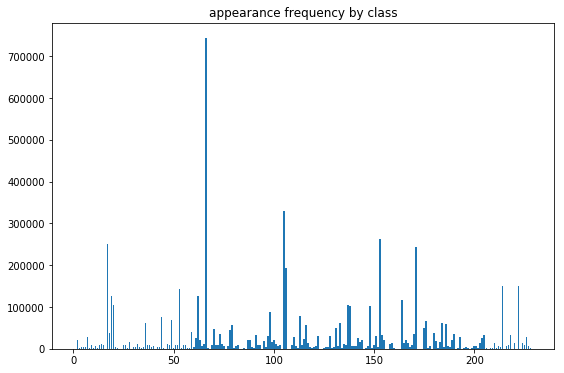

In [6]:
plt.figure(figsize=(9, 6));
plt.bar(x=range(1,229), height=totals);
plt.title('appearance frequency by class');

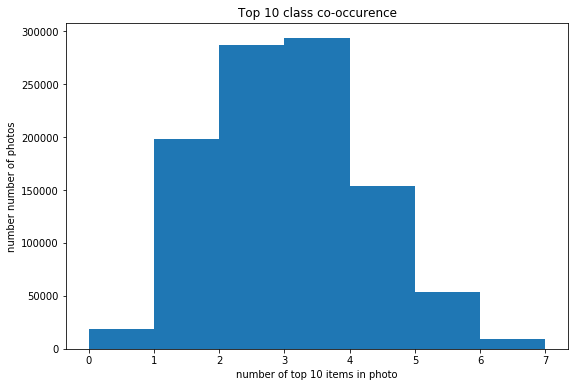

In [7]:
trunc_matrix = mat[:, top_n]
plt.figure(figsize=(9,6))
plt.hist(np.array(trunc_matrix.sum(axis=1))[:, 0], bins=7);
plt.title('Top {} class co-occurence'.format(n_classes));
plt.xlabel('number of top {} items in photo'.format(n_classes));
plt.ylabel('number number of photos');

In [8]:
len(np.argwhere(np.array(trunc_matrix.sum(axis=1))[:, 0]==0))/len(df)

0.018174667633932093

In [9]:
def download_image(url):
    """takes a url and returns a PIL image object."""
    try:
        response = requests.get(url)
    except:
        print('request failed.')
        return
    if response.status_code in [403, 404]:
        print('image not found.')
        return
    try:
        img = Image.open(BytesIO(response.content))
    except:
        print('could not open image.')
        return
    return img

def image_from_url(idx, df=df):
    """uses dataframe and index to lookup url
    and returns PIL image."""
    row = df.loc[idx]
    url = row['url']
    image = download_image(url)
    return image

def image_from_disk(idx, df=df, path_to_images='./train_imgs/'):
    """Loads an image from disk according to index idx.
    returns PIL image.
    """
    file = path_to_images + str(idx) + '.png'
    image = Image.open(file)
    return image

def image_as_tensor(image, xy_dims=(256, 256)):
    """takes a PIL image (image) and returns
    a numpy array with shape xy_dims (color channels
    last) scaled between 0 and 1.
    """
    res = image.resize(xy_dims)
    res = np.array(res)/255
    return res

def get_image(idx, filepath='./train_imgs/', df=df, xy_dims=(256, 256)):
    """attempts to load image from disk. If not found,
    downloads and saves to disk."""
    try:
        img = image_from_disk(idx, path_to_images=filepath)
        return image_as_tensor(img)
    except:
        img = image_from_url(idx, df=df)
        img = img.resize(xy_dims)
        #img.save(filepath + str(idx) + '.png')
        return image_as_tensor(img)
    
def input_batch(indices, filepath='./train_imgs/', df=df, xy_dims=(256, 256)):
    """Creates an input batch with given list of indices."""
    batch = []
    for idx in indices:
        batch.append(get_image(idx, filepath=filepath, df=df, xy_dims=xy_dims))
    batch = np.array(batch)
    return batch
    
def output_batch(indices, matrix=trunc_matrix, n_placeholders=2):
    """Creates an output batch with given list of indices."""
    batch = []
    for idx in indices:
        label_array = trunc_matrix[idx,:].toarray()[0,:]
        to_append = np.ones(n_placeholders)
        final_array = np.append(label_array, to_append)
        batch.append(final_array)
    batch = np.array(batch)
    return batch

In [11]:
shit_img = np.load('shit_img.npy')

def classify_ideal_images(df=df, model_path='ideal_classidier.h5', batch_size=1000, shit_img=shit_img):
    """Applies classifier model to images in df and returns a prediction vector
    of length len(df)"""
    from keras.models import load_model
    model = load_model(model_path)
    result = np.array([])
    batch_begin = 1
    batch_end = batch_begin + batch_size
    while batch_begin < max(df.index):
        progress = batch_begin/len(df)
        update_progress(progress)
        indices = [i for i in range(batch_begin, batch_end)]
        batch_begin += batch_size
        batch_end += min(batch_size, len(df)-batch_end)
        batch = input_batch(indices)
        prediction = model.predict(batch)
        for n, pred in enumerate(prediction):
            if np.array_equal(batch[n, :, :, :], shit_img):
                print('found some shit.')
                prediction[n, 0] = 0
        result = np.append(result, prediction)
        np.save('ideal_image_classes.npy', result)
    return result

result = classify_ideal_images()
np.save('images_ideal.npy', result)

Progress: [-------------------------] 0.0% found some shit.
Progress: [-------------------------] 0.01% found some shit.
Progress: [-------------------------] 0.01% 